In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

## Thought log
Ideas kept in cronological order.

#### 1. 2020/01/17
A goal worth seeking is to be able to use the results from one-shot denoising or
inpainting in order to quickly evaluate different network architectures. This 
would allow the speed up of network architecture search.

To use such one-shot evaluations, it must be known what qualities of a network
they measure. 

Some possible ideas:
* good denoising results suggest that when learning algorithm is applied, the
  learning process descends to optimum parameter sets which have one or both of 
  the following properties:
    1. earlier layers contribute most to the output.
    2. a large number of parameters contribute to the output.


Some questions:
* why haven't I had any success training with SGD, but success with Adam?
* why are the results so sensitive to learning rate?
* maybe the effectiveness is a better indicator of appropriate learning rate 
  (rather than being indicative of a good network structure). 
  
#### 2. 2020/01/25
Prof. Ishikawa pointed out that my understanding of the last layer of the 
network was very much wrong. I had previously imagined 3 bias elements present 
for every output pixel, which is (now obviously) not the case--there only biases
present for each element of the deconvolution kernel. The number of such 
elements is far smaller than the number of pixels in the image.

This fact undermines proposition 2. I can image a case where the last layer or 
two just work together to define some sort of simple section algorithm. For 
example, the kernel of the last layer unrolls channel 1-12 into the 12 numbers 
for a 4x4 section of the image. This would mean that the output is present in 
the second last layer just squashed into the channels in some specific order. It 
would be good to train the network to completion and investigate the last few 
layers to see where the pixel values come from. 

#### 3. 2020/01/28
Results from 

# Investigate results from "Deep Image Prior" paper
Try to investigate some of the following claims and questions.

## 1. Learning differences between layers explains one-shot denoising results.
Proposition 1: back-propagation with gradient descent favors the stabilization
of earlier layers before later layers. 

In more detail: the gradient of parameters in earlier layers must become small 
enough so that updates to  parameters in later layers will reduce the loss in 
expectation. As the gradient of earlier parameters reduces from large to small, 
the probability of a later parameter making a constructive contribution 
(reducing loss) increases from 50% towards 100%. 

Proposition 2: without contribution from the final layer, it is not possible to
recreate single pixel noise. without contribution from the second last layer,
it is not possible to recreate noise blocks of size 2x2. 
\[From update 2 above, this proposition seems likely to be false.\]

Argument:
Proposition 1
Proposition 2
Therefore, a network's ability to model noise improves as training stabilizes. 

There is no notion of "naturalness" covered by this argument.

### 1.1 Experiment 1
Train a network to output a noisy image from input noise.
Measure:
* the update distance for all layers. 
* the contribution distribution for the last layer.
* the output accuracy.
* the output accuracy for the noisy pixels.

#### 1.1.1 Evidence for proposition 1
Approximate layer stability with the update distance for each layer. Might need
some normalization. Fix some stability threshold. A strong relationship between 
layer number and time until reaching the  stability threshold is evidence for 
proposition 1.

#### 1.1.2 Evidence for proposition 2 
If there is a strong positive relationship between the accuracy for the noisy 
pixels and the contribution distribution for the last layer-this is evidence 
for proposition 2. 

#### Setup
Adam optimizer. Learning rate: 0.003. 

Gradient measure as follows:
```Python
def summarize_gradients_by_layer(grad_var_pairs):                               
    layer_to_grad = {}                                                          
    for layer_name, grads in gradients_by_layer(grad_var_pairs).items():        
        layer_dist = tf.add_n([tf.nn.l2_loss(v) for v in grads])                
        # Normalize by no. of params.                                           
        param_count = tf.add_n([tf.size(v, out_type=tf.float32) for v in grads])
        layer_dist /= param_count                                               
        layer_to_grad[layer_name] = layer_dist                                  
    return layer_to_grad     
```

#### 1.1.3 Results
The training didn't converge to the image. It approached it, but then 'lost'
the image and approached flat colors, occassionally jumping to different 
flat colors with some intermediate transcient artifacts.

In [2]:
import numpy as np
import matplotlib.pyplot as plt                                                        
import csv
import pandas as pd
import pprint
from collections import defaultdict

pp = pprint.PrettyPrinter()
                                                                                       
# [layer1, layer2, ...layerN, loss, psnr]
df = pd.read_pickle('../data/experiments/1/1/data.dataframe_pickle')
last_good_image_step = 5800

In [3]:
#pp.pprint(df.columns.to_list())
layer_names = df.columns.to_list()[2:]

In [4]:
win_size = 40
#smooth_df = df.rolling(win_size, center=True, win_type=None, min_periods=1).mean()
smooth_df = df.rolling(win_size, center=True, win_type='boxcar', min_periods=1).mean()

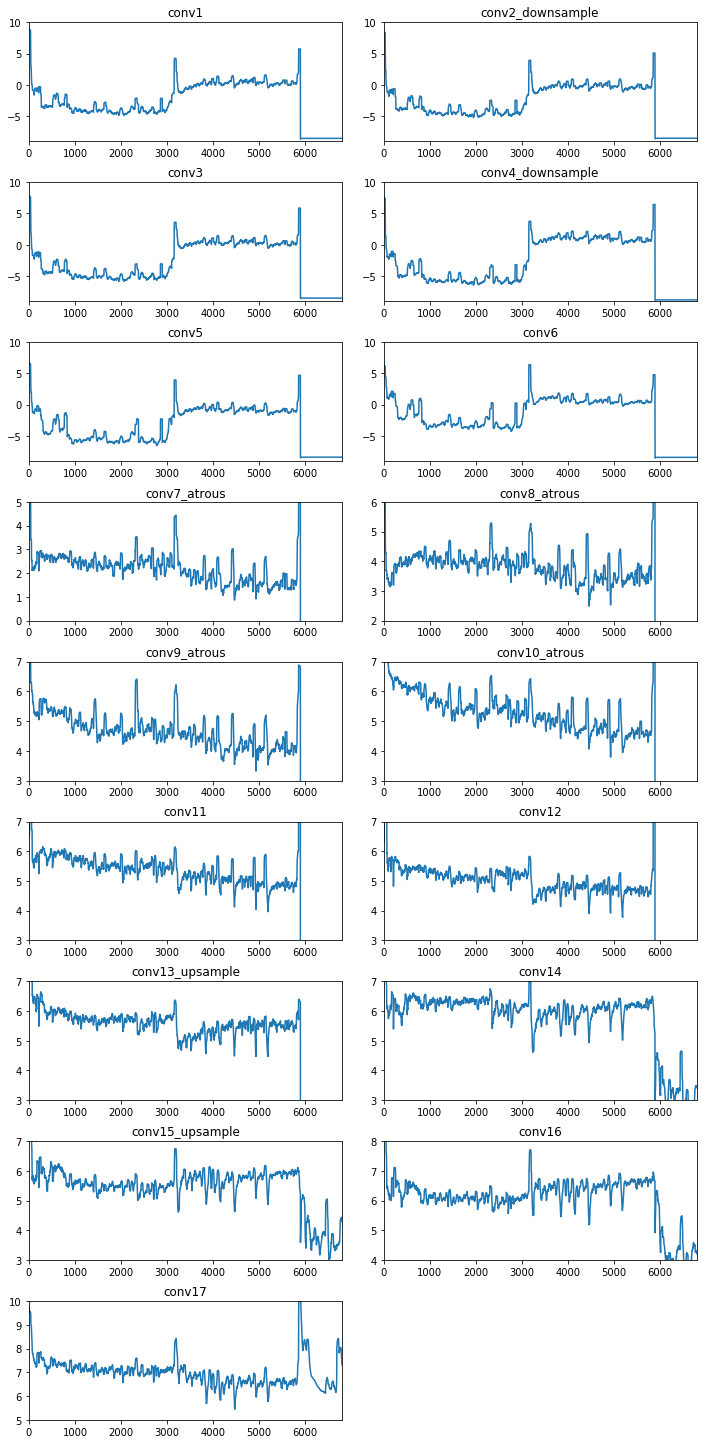

In [5]:
x_max = last_good_image_step + 1000

fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(10,20))
fig.tight_layout(h_pad=2)
axes_f = axes.flatten()
for i,layer_name in enumerate(layer_names):
    layer_id = i+1
    axes_f[i].set_title(f'{layer_name}')
    axes_f[i].plot(df.index, np.log10(smooth_df[f'{layer_name}'].values)) 
    axes_f[i].set_xlim(left=0, right=x_max)
# Disable the extra axes.
axes_f[-1].set_axis_off()
axes_f[0].set_ylim(bottom=-7, top=9)
for i in range(0,6):
    axes_f[i].set_ylim(bottom=-9, top=10)
axes_f[6].set_ylim(bottom=0, top=5)
axes_f[7].set_ylim(bottom=2, top=6)
for i in range(8, 15):
    axes_f[i].set_ylim(bottom=3, top=7)
axes_f[15].set_ylim(bottom=4, top=8)
axes_f[16].set_ylim(bottom=5, top=10)
fig.canvas.draw()